# E-Commerce Analysis - Clustering
### Blu LeBlanc
### Unsupervised Learning - Clustering

Goal: Utilize K-means to analyze e-commerce data and visualize findings. Perform dimension reduction.

Models to initialize:
- K-Means

Dataset: The dataset contains 5,000 e-commerce transactions from a Turkish online retail platform, spanning from January 2023 to March 2024. The dataset provides detailed insights into customer demographics, purchasing behavior, product preferences, and engagement metrics.
View DATASET_README.md for information about the dataset.

Citation:.\
E-Commerce Customer Behavior and Sales Dataset (2024).\
Turkish Online Retail Platform Data (2023-2024).\
Available on Kaggle

In [1]:
# Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Evaluation libraries
# Sklearn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Visual
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## EDA
**Step 1: Load and view dataset. Understand what data is available.** 

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/e-commerce-customer-behavior-and-sales-analysis-tr/ecommerce_customer_behavior_dataset.csv")

print("View Dataset")
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nHead: {df.head()}")

# basic stats with describe
print(f"\n\nData Stats: {df.describe()}")


View Dataset

Shape: (5000, 18)

Columns: ['Order_ID', 'Customer_ID', 'Date', 'Age', 'Gender', 'City', 'Product_Category', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 'Payment_Method', 'Device_Type', 'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer', 'Delivery_Time_Days', 'Customer_Rating']

Data Types:
Order_ID                     object
Customer_ID                  object
Date                         object
Age                           int64
Gender                       object
City                         object
Product_Category             object
Unit_Price                  float64
Quantity                      int64
Discount_Amount             float64
Total_Amount                float64
Payment_Method               object
Device_Type                  object
Session_Duration_Minutes      int64
Pages_Viewed                  int64
Is_Returning_Customer          bool
Delivery_Time_Days            int64
Customer_Rating               int64
dtype: objec

In [3]:
# Check missing vals
print("\nMissing Values")
missing = df.isnull().sum()
print(missing)


Missing Values
Order_ID                    0
Customer_ID                 0
Date                        0
Age                         0
Gender                      0
City                        0
Product_Category            0
Unit_Price                  0
Quantity                    0
Discount_Amount             0
Total_Amount                0
Payment_Method              0
Device_Type                 0
Session_Duration_Minutes    0
Pages_Viewed                0
Is_Returning_Customer       0
Delivery_Time_Days          0
Customer_Rating             0
dtype: int64


## Data Cleaning
**Step 2: Data Cleaning**
* According to dataset, the data has no missing values and the datatypes are formatted correctly.
* Traditionally, we would create a cleaning function -> Check missing vals, datatypes, invalid entries

## Data Processing
**Step 3: Data Processing**

Process the columns for clustering. Dataset is a snapshot of e-commerce transactions. Will need to standardize the data for clustering.

NOTE: New Changes.\
Previous implementation with minimal processing yielded around 30 features with very low silhouette scores (> 0.1) after dimension reduction.

**Solution:**.\
Create RFM features per customer. The current data is transaction level data, not customer level data. I will try to create Recency, Frequency, Monetary features per customer to get clusters with insights.

In [4]:
# Clean function -> Only change datetime
def clean(df):
    df_clean = df.copy()

    # Convert date
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])

    return df_clean
    
df_clean = clean(df)
print(f"\nHead: {df_clean.head()}")



Head:      Order_ID Customer_ID       Date  Age  Gender      City Product_Category  \
0  ORD_001337  CUST_01337 2023-01-01   27  Female     Bursa             Toys   
1  ORD_004885  CUST_04885 2023-01-01   42    Male     Konya             Toys   
2  ORD_004507  CUST_04507 2023-01-01   43  Female    Ankara             Food   
3  ORD_000645  CUST_00645 2023-01-01   32    Male  Istanbul      Electronics   
4  ORD_000690  CUST_00690 2023-01-01   40  Female  Istanbul           Sports   

   Unit_Price  Quantity  Discount_Amount  Total_Amount    Payment_Method  \
0       54.28         1             0.00         54.28        Debit Card   
1      244.90         1             0.00        244.90       Credit Card   
2       48.15         5             0.00        240.75       Credit Card   
3      804.06         1           229.28        574.78       Credit Card   
4      755.61         5             0.00       3778.05  Cash on Delivery   

  Device_Type  Session_Duration_Minutes  Pages_Viewed  

In [5]:
# Customer Aggregation
# get reference date for recency
reference_date = df_clean['Date'].max()
print(f"Reference Date (most recent transaction): {reference_date}")

def get_mode(x):
    # get mode value
    mode = x.mode()
    return mode.iloc[0] if len(mode) > 0 else x.iloc[0]

Reference Date (most recent transaction): 2024-03-26 00:00:00


In [6]:
# Aggregate to customer level
# No repeat customers found - no need for frequency metrics
customer_df = df_clean.groupby('Customer_ID').agg(
    # RFM
    Recency=('Date', lambda x: (reference_date - x.max()).days),
    Monetary_Total=('Total_Amount', 'sum'),
    
    # Behavioral
    Quantity=('Quantity', 'mean'),
    Session_Duration=('Session_Duration_Minutes', 'mean'),
    Pages_Viewed=('Pages_Viewed', 'mean'),
    Delivery_Time=('Delivery_Time_Days', 'mean'),
    Rating=('Customer_Rating', 'mean'),
    Total_Discount=('Discount_Amount', 'sum'),
    
    # Customer characteristics
    Age=('Age', 'first'),
    Gender=('Gender', 'first'),
    City=('City', 'first'),
    
    # mode of choice for customer
    Preferred_Category=('Product_Category', get_mode),
    Preferred_Payment=('Payment_Method', get_mode),
    Preferred_Device=('Device_Type', get_mode)
    
).reset_index()

# extra features
customer_df['Discount_Rate'] = customer_df['Total_Discount'] / customer_df['Monetary_Total']
customer_df['Discount_Rate'] = customer_df['Discount_Rate'].fillna(0)

# Check results
print("Customer Data")
print(f"Original transactions: {df_clean.shape[0]}")
print(f"Unique customers: {customer_df.shape[0]}")
print(f"Features per customer: {customer_df.shape[1]}")
print(f"\nColumns: {customer_df.columns.tolist()}")
print(f"\nHead:\n{customer_df.head()}")
print(f"\nDescriptive Stats:\n{customer_df.describe()}")


Customer Data
Original transactions: 5000
Unique customers: 5000
Features per customer: 16

Columns: ['Customer_ID', 'Recency', 'Monetary_Total', 'Quantity', 'Session_Duration', 'Pages_Viewed', 'Delivery_Time', 'Rating', 'Total_Discount', 'Age', 'Gender', 'City', 'Preferred_Category', 'Preferred_Payment', 'Preferred_Device', 'Discount_Rate']

Head:
  Customer_ID  Recency  Monetary_Total  Quantity  Session_Duration  \
0  CUST_00001      123          219.32       4.0               8.0   
1  CUST_00002      393          332.34       2.0               3.0   
2  CUST_00003      438           66.44       1.0               9.0   
3  CUST_00004       71          112.65       1.0               9.0   
4  CUST_00005      310          349.45       5.0              13.0   

   Pages_Viewed  Delivery_Time  Rating  Total_Discount  Age Gender      City  \
0           9.0            8.0     4.0             0.0   40   Male    Ankara   
1           8.0            8.0     5.0             0.0   33   Male  

**Encode Categorical Features & Scale Data**

In [7]:
# drop customer ID
df_cluster = customer_df.drop('Customer_ID', axis=1)

# encode categorical variables
categorical_cols = ['Gender', 'City', 'Preferred_Category', 'Preferred_Payment', 'Preferred_Device']
df_encoded = pd.get_dummies(df_cluster, columns = categorical_cols, drop_first = True)

print("Encoded Data")
print(f"Shape after encoding: {df_encoded.shape}")
print(f"Columns: {df_encoded.columns.tolist()}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print(f"\nScaled data shape: {X_scaled.shape}")

Encoded Data
Shape after encoding: (5000, 34)
Columns: ['Recency', 'Monetary_Total', 'Quantity', 'Session_Duration', 'Pages_Viewed', 'Delivery_Time', 'Rating', 'Total_Discount', 'Age', 'Discount_Rate', 'Gender_Male', 'Gender_Other', 'City_Ankara', 'City_Antalya', 'City_Bursa', 'City_Eskisehir', 'City_Gaziantep', 'City_Istanbul', 'City_Izmir', 'City_Kayseri', 'City_Konya', 'Preferred_Category_Books', 'Preferred_Category_Electronics', 'Preferred_Category_Fashion', 'Preferred_Category_Food', 'Preferred_Category_Home & Garden', 'Preferred_Category_Sports', 'Preferred_Category_Toys', 'Preferred_Payment_Cash on Delivery', 'Preferred_Payment_Credit Card', 'Preferred_Payment_Debit Card', 'Preferred_Payment_Digital Wallet', 'Preferred_Device_Mobile', 'Preferred_Device_Tablet']

Scaled data shape: (5000, 34)


## K-Means Clustering
**Basic Cluster Implement**

In [8]:
# Setting k = 4 clusters

print("Basic Clustering without PCA")
print(f"Feature dimensions: {X_scaled.shape[1]}")

baseline_silhouette = []
baseline_inertias = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    baseline_silhouette.append(sil)
    baseline_inertias.append(kmeans.inertia_)
    
    print(f"k={k:2d}: Silhouette={sil:.3f}")

print(f"\nBest k: {baseline_silhouette.index(max(baseline_silhouette)) + 2}")
print(f"Best Silhouette: {max(baseline_silhouette):.3f}")

Basic Clustering without PCA
Feature dimensions: 34
k= 2: Silhouette=0.041
k= 3: Silhouette=0.044
k= 4: Silhouette=0.061
k= 5: Silhouette=0.076
k= 6: Silhouette=0.083
k= 7: Silhouette=0.083
k= 8: Silhouette=0.107
k= 9: Silhouette=0.113
k=10: Silhouette=0.094
k=11: Silhouette=0.096
k=12: Silhouette=0.113
k=13: Silhouette=0.102
k=14: Silhouette=0.103

Best k: 12
Best Silhouette: 0.113


Overall, weak silhouette score. 12 clusters is very high as well. 

SOLUTION: Perform PCA Dimension reduction, then find optimal cluster count

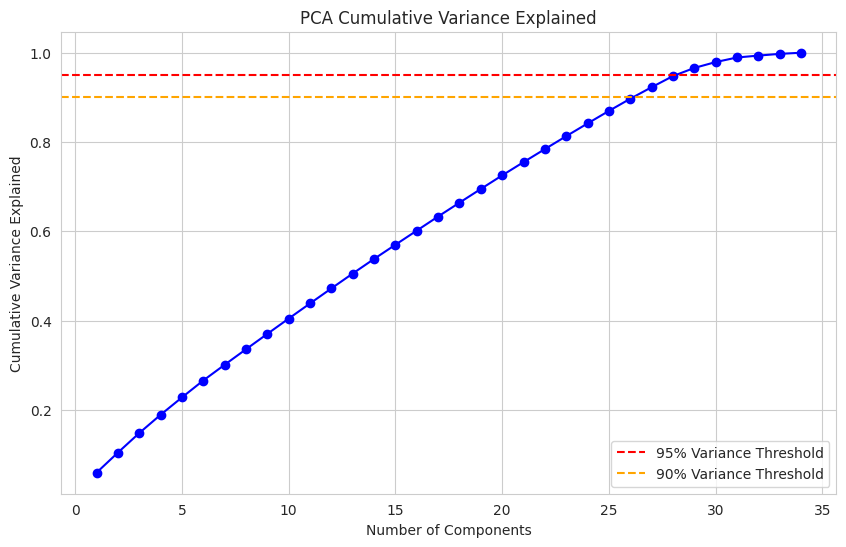

Components for 90% variance: 27
Components for 95% variance: 29


In [9]:
# get PCA components
pca_full = PCA()
pca_full.fit(X_scaled)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance Threshold')
plt.title('PCA Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

n_components_95 = np.argmax(cumsum >= 0.95) + 1
n_components_90 = np.argmax(cumsum >= 0.90) + 1
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")

In [10]:
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced dimensions: {X_scaled.shape[1]} → {X_pca.shape[1]}")

Reduced dimensions: 34 → 29


In [11]:
print("Clustering with PCA")
print(f"Feature dimensions: {X_pca.shape[1]}")

baseline_silhouette = []
baseline_inertias = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    sil = silhouette_score(X_pca, labels)
    baseline_silhouette.append(sil)
    baseline_inertias.append(kmeans.inertia_)
    
    print(f"k={k:2d}: Silhouette={sil:.3f}")

print(f"\nBest k: {baseline_silhouette.index(max(baseline_silhouette)) + 2}")
print(f"Best Silhouette: {max(baseline_silhouette):.3f}")

kmeans_final = KMeans(n_clusters=8, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans_final.fit_predict(X_pca)

Clustering with PCA
Feature dimensions: 29
k= 2: Silhouette=0.042
k= 3: Silhouette=0.047
k= 4: Silhouette=0.070
k= 5: Silhouette=0.078
k= 6: Silhouette=0.098
k= 7: Silhouette=0.088
k= 8: Silhouette=0.108
k= 9: Silhouette=0.101
k=10: Silhouette=0.107
k=11: Silhouette=0.113
k=12: Silhouette=0.114
k=13: Silhouette=0.105
k=14: Silhouette=0.101

Best k: 12
Best Silhouette: 0.114


**Viewing initial results**

With 0.114 maximum silhouette score, there is likely no distinct customer segments. With k = 12 clusters, there is most likely arbitrary patterns. Instead of k = 12 clusters, I want to analyze the kmeans model with k = 8 clusters instead. The silhouette score is the smallest value that still has a large silhouette score.

In [12]:
# Basic cluster analysis

print("Cluster Profiles")


# Cluster sizes
print(f"\nCluster Sizes:")
cluster_sizes = customer_df['Cluster'].value_counts().sort_index()
print(cluster_sizes)
print(f"\nCluster Proportions:")
print((cluster_sizes / len(customer_df) * 100).round(1).astype(str) + '%')

# Numeric features profile
numeric_cols = ['Recency', 'Monetary_Total', 'Quantity', 'Discount_Rate',
                'Session_Duration', 'Pages_Viewed', 'Delivery_Time', 
                'Rating', 'Age']

cluster_profile = customer_df.groupby('Cluster')[numeric_cols].mean()
print(f"\nCluster Means (Numeric Features):\n{cluster_profile.round(2).T}")

# Categorical preferences by cluster
print(f"\nCategorical Distributions by Cluster")

print(f"\nProduct Category:")
print(pd.crosstab(customer_df['Cluster'], customer_df['Preferred_Category'], normalize='index').round(3) * 100)

print(f"\nPayment Method:")
print(pd.crosstab(customer_df['Cluster'], customer_df['Preferred_Payment'], normalize='index').round(3) * 100)

print(f"\nDevice Type:")
print(pd.crosstab(customer_df['Cluster'], customer_df['Preferred_Device'], normalize='index').round(3) * 100)

print(f"\nGender:")
print(pd.crosstab(customer_df['Cluster'], customer_df['Gender'], normalize='index').round(3) * 100)

Cluster Profiles

Cluster Sizes:
Cluster
0     592
1     636
2     599
3     209
4     587
5    1185
6     590
7     602
Name: count, dtype: int64

Cluster Proportions:
Cluster
0    11.8%
1    12.7%
2    12.0%
3     4.2%
4    11.7%
5    23.7%
6    11.8%
7    12.0%
Name: count, dtype: object

Cluster Means (Numeric Features):
Cluster                0        1       2       3       4       5       6  \
Recency           223.34   219.25  224.33  223.44  227.19  220.86  220.13   
Monetary_Total    363.11  1147.02  601.96  842.58  116.65  845.67  152.91   
Quantity            2.24     2.28    2.27    2.19    2.09    2.24    2.19   
Discount_Rate       0.04     0.04    0.04    0.04    0.04    0.04    0.03   
Session_Duration   14.09    15.22   15.00   15.11   14.20   14.31   14.55   
Pages_Viewed        8.85     8.90    9.22    9.08    9.02    9.02    8.84   
Delivery_Time       6.43     6.67    6.48    6.64    6.47    6.42    6.65   
Rating              3.90     3.90    3.87    3.83    3.98

## Findings
**Findings from Unsupervised Clustering**.\
The K-means algorithm has essentially created product category segments for clusters. There are different monetary amounts for specific clusters that can yield some insights. In general, the other variables are homogenous across clusters.\

Notable Clusters:.\
Premium Buyers - Cluster 7 - Electronics - $3,777

Sports Buyers - Cluster 1 - Sports - $1,147

Diverse Buyers - Cluster 3 - Mixed catergories - $843

Food Buyers - Cluster 6 - Food - $153

Book Buyers - Cluster 4 - Books - $117


Electronic drives disproportionate revenue. A single Electronics customer is worth ~32x a Books customer.

Customer behavior is identical regardless of what they buy. Only differences are product choice and spend level.

*Cluster 3 is unique with 11% - 13% of each product category and only 4.2% size compared to the other clusters. The spending is higher at $843. Would need a domain expert to explain. Hypothesis: Gift shoppers, new customers, or higher-income customers.

**Insights**.\
Prioritize Electronics marketing.

Books/Food are low value products. Address that with bundle deals/marketing

Homogenous Customer behavior. No persona-based advertisement needed.

Category determines cluster value.

## Conclusion
Overall, we can glean some insights from our unsupervised clustering method with k-means. Honestly, our clusters did not reveal any hidden segments, only category-based differences. The same conclusions could be obtained from basic direct category analysis, filtering the dataset based on product category and displaying findings.

**Future Work**.\
Option 1. Perform clustering after removing category variables to try to uncover hidden meanings.

Option 2. Try alternative methods to gain business insights, such as supervised learning, data exploration/visualization, or hypothesis testing

